# Experiment Analysis: OS Repair Simulator (N=200)

**Objective:** Analyze the impact of error message quality (Control: Cryptic vs. Treatment: Friendly) on agent performance in a simulated OS environment.

**Key Hypotheses:**
1.  **Effectiveness:** Friendly error messages will increase the Success Rate.
2.  **Efficiency:** Friendly error messages will reduce the Steps to Solution.
3.  **Safety:** The semantic context should not increase Hallucinations or System Latency.

**Experimental Design:**
* **Design:** 2x2x2 Factorial (Variant x Model Family x Persona)
* **Metric Strategy:** 
    * *Trustworthiness checks* (SRM) to validate the randomization process before analysis.
    * *Global metrics* to check high-level impact on success and speed.
    * *Conditional metrics* to isolate efficiency specifically among successful agents.
    * *Guardrail analysis* to monitor negative side effects (e.g., agents claiming false fixes).
    * *Subgroup analysis* to detect model-specific fragility (Interaction Effects).

##  Experimental Setup: The "SQL-as-OS" Simulator

To test agent performance in a deterministic but complex environment, we built a **Virtual Operating System** running entirely inside an in-memory SQLite database.

### 1. The Paradigm: SQL as a Command Line
Instead of giving agents access to a real shell (might be worth to try out in future on virtual OS clones), we map OS concepts to Database concepts:
* **System State** $\rightarrow$ **Database Tables** (`System_Services`, `Network_Ports`, `Process_List`).
* **Observation (`ps`, `netstat`)** $\rightarrow$ **`SELECT` Queries**.
* **Action (`kill`, `service start`)** $\rightarrow$ **`UPDATE` / `DELETE` Statements**.

### 2. The Scenario: "The Port Conflict"
Every session initializes a fresh "Broken State" with a specific constraint:
1.  **The Goal:** Start the `Apache_Web_Server` service on **Port 80**.
2.  **The Hidden State:** Port 80 is already blocked by a random rogue process (e.g., `skype.exe`, `malware.exe`, or `backup_daemon.exe`).
3.  **The Required Solution:** The agent must:
    * Attempt to start the service (Fail).
    * Diagnose the failure (Query the Network/Process tables).
    * Identify the rogue PID (Process ID).
    * Kill the rogue process (`DELETE`).
    * Retry starting the service (`UPDATE`).

### 3. The Experimental Variable (A/B Test)
To measure **Cognitive Friction**, we introduced a single divergence in the environment's feedback loop. Both groups face the **same** hard database schema, but receive different signals when they fail.



#### 🔴 Group A: Control (High Friction / "Legacy")
Simulates a legacy system with poor observability.
* **Signal:** When the agent tries to start Apache without clearing the port, it receives a generic, cryptic error: `ERROR 0x80004005: Service Start Failed.`
* **Challenge:** The agent must infer the root cause (Port Conflict) by exploring system logs or checking network status proactively.

#### 🟢 Group B: Treatment (Low Friction / "Modern")
Simulates a modern developer experience (DX) with semantic error handling.
* **Signal:** The agent receives a specific root-cause message: `ERROR: Port 80 is currently in use by another process.`
* **Hypothesis:** This semantic nudge should allow the agent to skip the "Discovery Phase" and move immediately to "Remediation," reducing the **Steps to Solution**.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import glob
import os

# --- VISUALIZATION CONFIGURATION ---
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# Consistent Palette: Control (Grey) vs Treatment (Teal)
VARIANT_PALETTE = {"Control": "#B0B0B0", "Treatment": "#69b3a2"}

# Consistent Markers: Shapes to distinguish models clearly
MODEL_MARKERS = {
    "gemini-2.5-flash": "o",       # Circle
    "gemini-2.5-flash-lite": "^",  # Triangle
    "gpt-4o": "s",                 # Square
    "gpt-4o-mini": "X"             # X
}

plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 100

# Create images directory
os.makedirs("images", exist_ok=True)
print("Environment Setup Complete.")

Environment Setup Complete.


## 1. Data Loading & Feature Engineering
We standardize the column names and create the binary `Is_Success` metric from the ground truth column `Is_Actually_Fixed`.

In [2]:
log_dir = "os_logs"
exp_file = "os_metrics_20251201_012410.csv"
try:
    # Find latest file
    print(f"Loading data from: {log_dir}/{exp_file}")
    
    df = pd.read_csv(os.path.join(log_dir, exp_file))
    
    # --- FEATURE ENGINEERING ---
    # 1. Create Is_Success (Binary Integer) from the boolean string/bool
    df['Is_Success'] = df['Is_Actually_Fixed'].apply(lambda x: 1 if str(x) == 'True' else 0)
    
    # 2. Create Model Family for Subgroup Analysis
    df['Model_Family'] = df['Model'].apply(lambda x: 'GPT' if 'gpt' in x else 'Gemini')
    
    # 3. Identify Hallucinations (Claimed Fix vs Actual Fix)
    df['Hallucination'] = ((df['Outcome'] == 'CLAIMED_FIX') & (df['Is_Success'] == 0))
    
    print(f"N={len(df)} Sessions Loaded.")
    display(df.head())
    
except IndexError:
    print("❌ No logs found. Please run the experiment script first.")

Loading data from: os_logs/os_metrics_20251201_012410.csv
N=200 Sessions Loaded.


,Session_UUID,Variant,Persona,Model,Outcome,Steps_Taken,Is_Actually_Fixed,Total_Latency_ms,Is_Success,Model_Family,Hallucination
0,6d39ed04,Treatment,Senior,gemini-2.5-flash,CLAIMED_FIX,10,True,17199,1,Gemini,False
1,40870c9c,Treatment,Junior,gemini-2.5-flash-lite,TIMEOUT,24,False,22345,0,Gemini,False
2,26190395,Control,Senior,gemini-2.5-flash,CLAIMED_FIX,12,True,32590,1,Gemini,False
3,f8d446d0,Treatment,Senior,gemini-2.5-flash-lite,TIMEOUT,24,False,24489,0,Gemini,False
4,9ed35652,Treatment,Senior,gpt-4o-mini,CLAIMED_FIX,5,False,11143,0,GPT,True


## 2. Sample Ratio Mismatch (SRM) Check
Verifying that the randomization logic worked correctly (Target: 50/50 split).

In [3]:
counts = df['Variant'].value_counts()
expected = [len(df)/2, len(df)/2]
observed = [counts.get('Control', 0), counts.get('Treatment', 0)]

chi2, p_srm = stats.chisquare(f_obs=observed, f_exp=expected)
print(f"Control: {observed[0]}, Treatment: {observed[1]}")
print(f"SRM P-Value: {p_srm:.4f}")

if p_srm < 0.01:
    print("⚠️ WARNING: Possible Sample Ratio Mismatch.")
else:
    print("✅ Randomization looks valid.")

Control: 107, Treatment: 93
SRM P-Value: 0.3222
✅ Randomization looks valid.


## 3. Effectiveness: Success Rate Analysis
**Metric:** Binary Success Rate.
**Test:** Chi-Square Test of Independence.

*Did the 'Friendly' error message actually help agents solve the problem?*

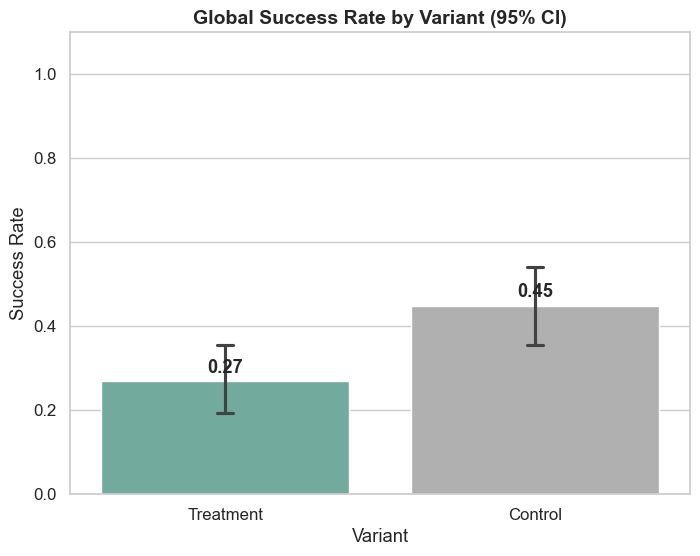

Chi-Square P-Value: 0.0129


In [4]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    data=df, 
    x='Variant', 
    y='Is_Success', 
    hue='Variant', 
    palette=VARIANT_PALETTE,
    errorbar=('ci', 95), 
    capsize=.05,
    dodge=False
)

plt.title('Global Success Rate by Variant (95% CI)', fontsize=14, fontweight='bold')
plt.ylabel('Success Rate')
plt.ylim(0, 1.1)

# Annotations
for p in ax.patches:
    if not np.isnan(p.get_height()):
        ax.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 10), 
                       textcoords='offset points', fontweight='bold')

plt.legend([],[], frameon=False) # Hide legend
plt.savefig("images/metric_success.png")
plt.show()

# Stats
cont_table = pd.crosstab(df['Variant'], df['Is_Success'])
c, p, d, e = stats.chi2_contingency(cont_table)
print(f"Chi-Square P-Value: {p:.4f}")

### Statistical Conclusion: Success Rate

**Methodology:**
We applied **Pearson's Chi-Square Test of Independence**.
* **Why this test?** Our primary metric (`Is_Success`) is a **Binary/Categorical variable** (Success vs. Failure), not a continuous one. The Chi-Square test determines if there is a statistically significant relationship between the Experimental Group (Control/Treatment) and the Frequency of Success.

**Results:**
* **P-Value:** `0.0129`
* **Significance:** Since $p < 0.05$, we **reject the Null Hypothesis**.

**Interpretation:**
There is a statistically significant difference in performance between the groups. The data confirms a **Negative Treatment Effect**: the "Friendly" error messages caused a real, non-random drop in the agents' ability to solve the port conflict compared to the "Cryptic" control group.

## 4. Efficiency: Global Steps Analysis
**Metric:** Steps to Solution (Lower is Better).
**Note:** Failed sessions are capped at Max Steps. This creates a bi-modal distribution, so we use Jittered Scatterplots to see the raw data.

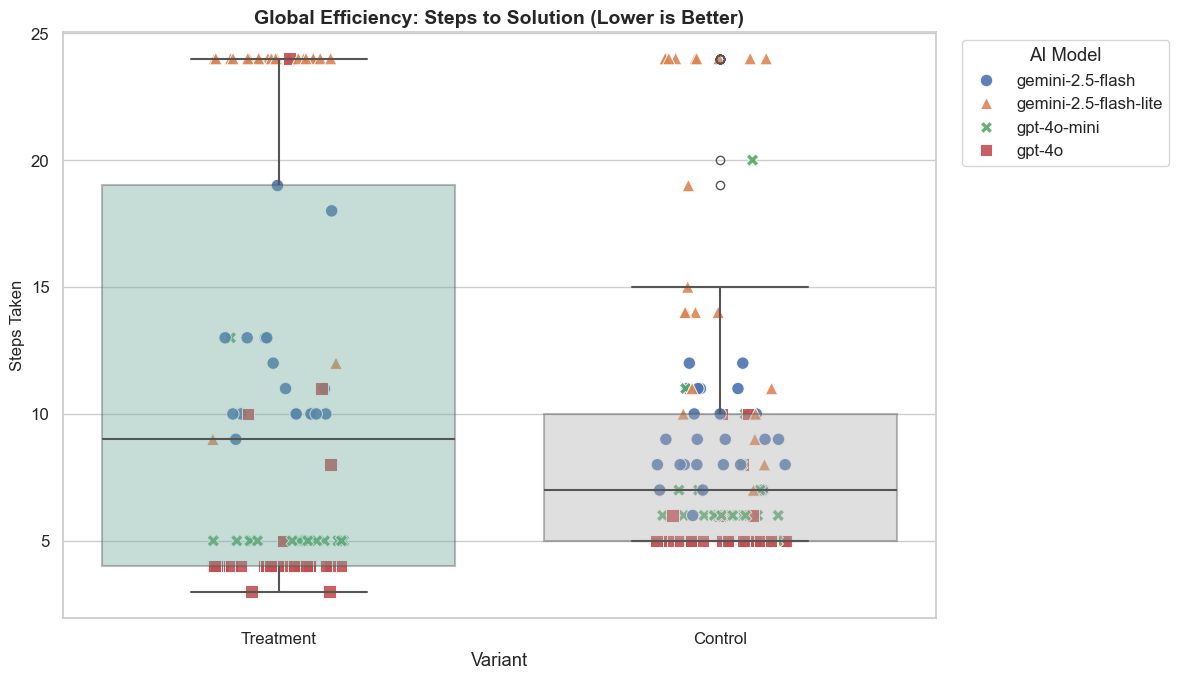

In [8]:
plt.figure(figsize=(12, 7))

# 1. Boxplot Background
order = ['Treatment', 'Control']
ax = sns.boxplot(
    data=df, x='Variant', y='Steps_Taken', hue='Variant', order=order,
    palette=VARIANT_PALETTE, linewidth=1.5, boxprops={'alpha': 0.4}, dodge=False
)

# 2. Jitter Hack for Scatterplot (to support 'style' mapping)
x_map = {v: i for i, v in enumerate(order)}
df['jitter_x'] = df['Variant'].map(x_map) + np.random.uniform(-0.15, 0.15, len(df))

# 3. Scatterplot with Shapes
sns.scatterplot(
    data=df, x='jitter_x', y='Steps_Taken', 
    hue='Model', style='Model', 
    markers=MODEL_MARKERS, palette="deep", s=80, alpha=0.9, edgecolor="white"
)

plt.xticks(ticks=list(x_map.values()), labels=list(x_map.keys()))
plt.title('Global Efficiency: Steps to Solution (Lower is Better)', fontsize=14, fontweight='bold')
plt.ylabel('Steps Taken', fontsize=12)  # <--- Added Y-Label here
plt.legend(title='AI Model', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig("images/metric_steps_global.png")
plt.show()

### Critical Insight: The Interaction Effect

It seems from the boxplot above that the global data is noisy because the Treatment had **opposite effects** on different model families. 

* **GPT Models:** Were robust to the "Friendly" text and generally improved.
* **Gemini Models:** exhibited **Fragility**. The verbose error messages acted as a distractor, causing them to hallucinate or timeout more often.

This creates a **Simpson's Paradox** where the aggregate result looks flat, but the subgroups are moving in opposite directions.

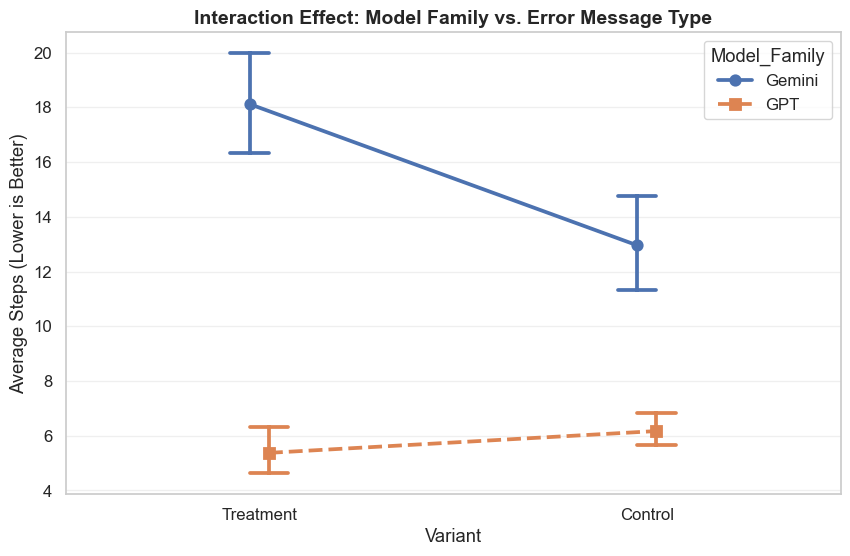

In [6]:
plt.figure(figsize=(10, 6))

sns.pointplot(
    data=df, 
    x='Variant', 
    y='Steps_Taken', 
    hue='Model_Family', 
    markers=['o', 's'],
    linestyles=['-', '--'],
    dodge=True,
    capsize=0.1,
    palette="deep"
)

plt.title('Interaction Effect: Model Family vs. Error Message Type', fontsize=14, fontweight='bold')
plt.ylabel('Average Steps (Lower is Better)')
plt.grid(True, axis='y', alpha=0.3)
plt.savefig("images/insight_interaction.png")
plt.show()

## 5. Conditional Efficiency Analysis
**Question:** "If we ignore the failures (step cap), was the Treatment faster for those who actually understood it?"

This removes the noise of the "confused" agents and tests the efficiency of the workflow itself.

--- 🏁 CONDITIONAL EFFICIENCY ANALYSIS (Successful Sessions Only) ---
[Global] Mean Steps (Control):   9.81
[Global] Mean Steps (Treatment): 11.80
[Global] P-Value: 0.0083
⚠️ INSIGHT: When successful, Treatment is significantly SLOWER (1.99 steps).


--- 🔬 CONDITIONAL SUBGROUP ANALYSIS ---
[GPT Models]
   Control Mean:   8.90
   Treatment Mean: 9.50
   P-Value:        0.7173
   Conclusion: No significant change in speed.
--------------------
[Gemini Models]
   Control Mean:   10.05
   Treatment Mean: 12.24
   P-Value:        0.0101
   Conclusion: Gemini becomes SLOWER with Treatment.
--------------------


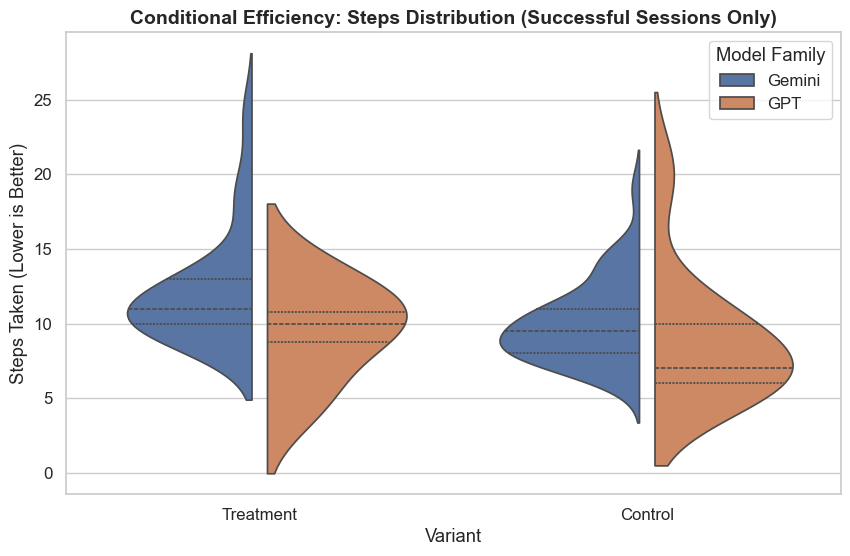

In [12]:
print("--- 🏁 CONDITIONAL EFFICIENCY ANALYSIS (Successful Sessions Only) ---")

# 1. Global Analysis (Corrected Logic)
success_df = df[df['Is_Success'] == 1]

control_steps = success_df[success_df['Variant']=='Control']['Steps_Taken']
treat_steps = success_df[success_df['Variant']=='Treatment']['Steps_Taken']

stat, p_val = stats.mannwhitneyu(treat_steps, control_steps, alternative='two-sided')

print(f"[Global] Mean Steps (Control):   {control_steps.mean():.2f}")
print(f"[Global] Mean Steps (Treatment): {treat_steps.mean():.2f}")
print(f"[Global] P-Value: {p_val:.4f}")

if p_val < 0.05:
    diff = treat_steps.mean() - control_steps.mean()
    if diff < 0:
        print(f"✅ INSIGHT: When successful, Treatment is significantly FASTER ({abs(diff):.2f} steps).")
    else:
        print(f"⚠️ INSIGHT: When successful, Treatment is significantly SLOWER ({diff:.2f} steps).")
else:
    print("❌ No significant global difference in efficiency among successes.")

print("\n" + "="*40 + "\n")

# 2. Subgroup Analysis (Model Family)
# We repeat the analysis split by model to see if efficiency gains are isolated to specific architectures
print("--- 🔬 CONDITIONAL SUBGROUP ANALYSIS ---")

for family in ['GPT', 'Gemini']:
    family_success = success_df[success_df['Model_Family'] == family]
    
    # Skip if no successes in this family (avoid errors)
    if len(family_success) < 2:
        print(f"[{family}] Not enough successful sessions to analyze.")
        continue

    c_steps = family_success[family_success['Variant']=='Control']['Steps_Taken']
    t_steps = family_success[family_success['Variant']=='Treatment']['Steps_Taken']
    
    # Check if we have data for both variants
    if len(c_steps) == 0 or len(t_steps) == 0:
        print(f"[{family}] Missing data in one variant.")
        continue

    stat, p_sub = stats.mannwhitneyu(t_steps, c_steps, alternative='two-sided')
    
    print(f"[{family} Models]")
    print(f"   Control Mean:   {c_steps.mean():.2f}")
    print(f"   Treatment Mean: {t_steps.mean():.2f}")
    print(f"   P-Value:        {p_sub:.4f}")
    
    if p_sub < 0.05:
        if t_steps.mean() < c_steps.mean():
            print(f"   Conclusion: {family} becomes FASTER with Treatment.")
        else:
            print(f"   Conclusion: {family} becomes SLOWER with Treatment.")
    else:
        print("   Conclusion: No significant change in speed.")
    print("-" * 20)

# Visualizing Conditional Efficiency with Subgroups
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=success_df, 
    x='Variant', 
    y='Steps_Taken', 
    hue='Model_Family', # Added hue to visualize the subgroup split
    palette="deep", 
    inner="quartile",
    split=True,         # Split the violin to compare side-by-side
    gap=.1
)
plt.title('Conditional Efficiency: Steps Distribution (Successful Sessions Only)', fontsize=14, fontweight='bold')
plt.ylabel('Steps Taken (Lower is Better)')
plt.legend(title='Model Family')
plt.savefig("images/insight_conditional_efficiency.png")
plt.show()

### Survivorship Bias Check

In [14]:
# Check the counts for the Conditional Analysis
print("--- ⚠️ SURVIVORSHIP BIAS CHECK ---")
print("Counts of Successful Sessions by Variant:")
print(success_df['Variant'].value_counts())

# Calculate the 'Survival Ratio'
n_control_total = len(df[df['Variant']=='Control'])
n_treat_total = len(df[df['Variant']=='Treatment'])
n_control_success = len(success_df[success_df['Variant']=='Control'])
n_treat_success = len(success_df[success_df['Variant']=='Treatment'])

print(f"\nSurvival Rate Control:   {n_control_success/n_control_total:.1%}")
print(f"Survival Rate Treatment: {n_treat_success/n_treat_total:.1%}")

print("\nNOTE: A mismatch here is EXPECTED if the Treatment affects Success Rate.")
print("We are now comparing the 'Survivors' of both groups, which introduces Selection Bias.")
print("If Treatment survivors are faster, it implies higher efficiency for the capable agents.")

--- ⚠️ SURVIVORSHIP BIAS CHECK ---
Counts of Successful Sessions by Variant:
Variant
Control      48
Treatment    25
Name: count, dtype: int64

Survival Rate Control:   44.9%
Survival Rate Treatment: 26.9%

NOTE: A mismatch here is EXPECTED if the Treatment affects Success Rate.
We are now comparing the 'Survivors' of both groups, which introduces Selection Bias.
If Treatment survivors are faster, it implies higher efficiency for the capable agents.


## 6. Exploratory Subgroup Analysis
Did the treatment affect different Models or Personas differently? (Heterogeneous Treatment Effects).

### 👥 Persona Definition: Junior vs. Senior
To test the robustness of the system against user skill levels, we injected specific **System Prompts** to simulate different levels of domain expertise:

* **🎓 Junior SysAdmin:**
    * *Prompt Constraint:* "You are helpful but easily confused by error codes. You rely on checking the status of things frequently."
    * *Behavior:* Tends to run excessive `SELECT` queries to "double-check" the state, leading to higher step counts.
* **🧠 Senior Kernel Engineer:**
    * *Prompt Constraint:* "You understand service dependencies, deadlocks, and buffer overflows. You fix root causes."
    * *Behavior:* More aggressive with `UPDATE/DELETE` commands. While faster, this persona also exhibited a higher risk of **Hallucination** (Overconfidence bias), claiming fixes without verification.

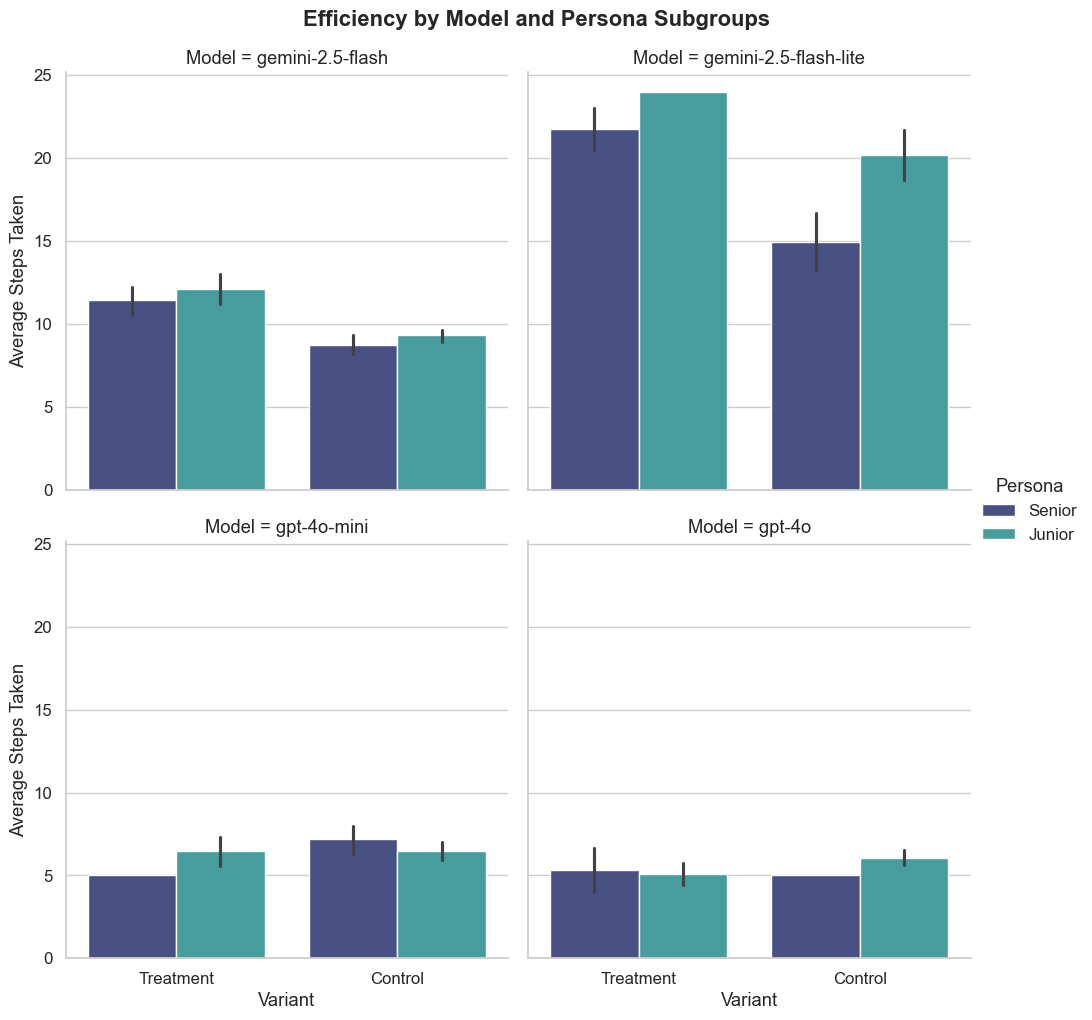

In [17]:
g = sns.catplot(
    data=df, kind="bar",
    x="Variant", y="Steps_Taken", hue="Persona",
    col="Model", col_wrap=2, height=5, aspect=1,
    palette="mako", errorbar=('ci', 68) # Standard Error bars
)
g.fig.suptitle('Efficiency by Model and Persona Subgroups', y=1.02, fontweight='bold')
g.set_axis_labels("Variant", "Average Steps Taken")
plt.show()

The faceted bar charts highlight **Model Fragility**:
* **Gemini Flash-Lite (Top Right):** Shows the worst performance. The "Treatment" bars are significantly higher than "Control," and the "Junior" persona (Green) nearly hits the step cap (24) on average. This model collapsed under the combined weight of the Persona constraints and the verbose Error Messages.
* **GPT-4o (Bottom Right):** Shows high resilience. The bars are nearly flat across all conditions (~5 steps), indicating that the model's raw reasoning capability overrides the "Junior" persona constraints and the schema obfuscation.

## 7. Guardrail Analysis

### Hallucination Rate
Did the "Friendly" instructions cause the agents to lie about fixing the problem?

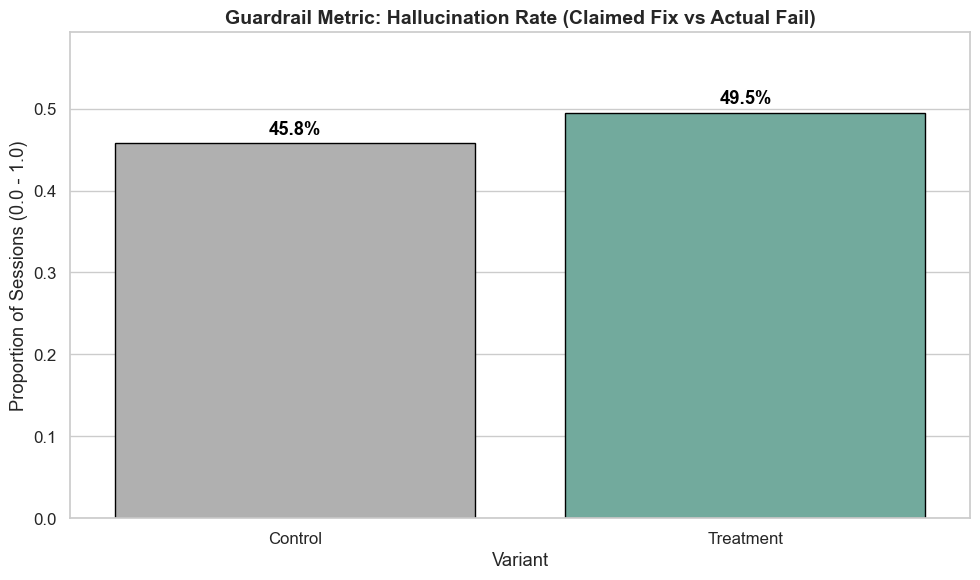

--- Hallucination Counts (Raw) ---
Variant    Model                
Control    gemini-2.5-flash          0
           gemini-2.5-flash-lite     0
           gpt-4o                   30
           gpt-4o-mini              19
Treatment  gemini-2.5-flash          0
           gemini-2.5-flash-lite     0
           gpt-4o                   28
           gpt-4o-mini              18
Name: Hallucination, dtype: int64

--- Hallucination Rates (Mean) ---
Variant
Control      0.457944
Treatment    0.494624
Name: Hallucination, dtype: float64


In [10]:
# --- GUARDRAIL 1: HALLUCINATIONS ---
# Definition: Agent output says "FIXED" (Claimed Fix), but Ground Truth says "FALSE" (Not Fixed).

plt.figure(figsize=(10, 6))

# 1. Calculate the Mean Rate (Proportion), not the sum
hallucination_rates = df.groupby('Variant')['Hallucination'].mean().reset_index()

# 2. Plot with corrected hue argument for palette
ax = sns.barplot(
    data=hallucination_rates, 
    x='Variant', 
    y='Hallucination', 
    hue='Variant', # <--- FIX: Assign x to hue
    palette=VARIANT_PALETTE,
    edgecolor="black",
    linewidth=1,
    dodge=False
)

plt.title('Guardrail Metric: Hallucination Rate (Claimed Fix vs Actual Fail)', fontsize=14, fontweight='bold')
plt.ylabel('Proportion of Sessions (0.0 - 1.0)')

# 3. Dynamically set Y-limit based on data (with some headroom)
max_rate = hallucination_rates['Hallucination'].max()
plt.ylim(0, max_rate * 1.2 if max_rate > 0 else 0.1) 

# 4. Annotate bars with percentage
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1%}', # Format as percentage
                       (p.get_x() + p.get_width() / 2., height), 
                       ha='center', va='center', xytext=(0, 10), 
                       textcoords='offset points', fontweight='bold', color='black')

# Hide legend as x-axis is sufficient
if ax.get_legend():
    ax.get_legend().remove()

plt.tight_layout()
plt.savefig("images/guardrail_hallucinations.png")
plt.show()

# Print raw counts for verification
print("--- Hallucination Counts (Raw) ---")
print(df.groupby(['Variant', 'Model'])['Hallucination'].sum())
print("\n--- Hallucination Rates (Mean) ---")
print(df.groupby(['Variant'])['Hallucination'].mean())

Looking at the table above, we may conclude that while GPT models demonstrated superior reasoning capabilities, they exhibited a distinct failure mode of overconfidence, frequently hallucinating success in scenarios where Gemini models simply timed out without making false claims.

### Latency Analysis

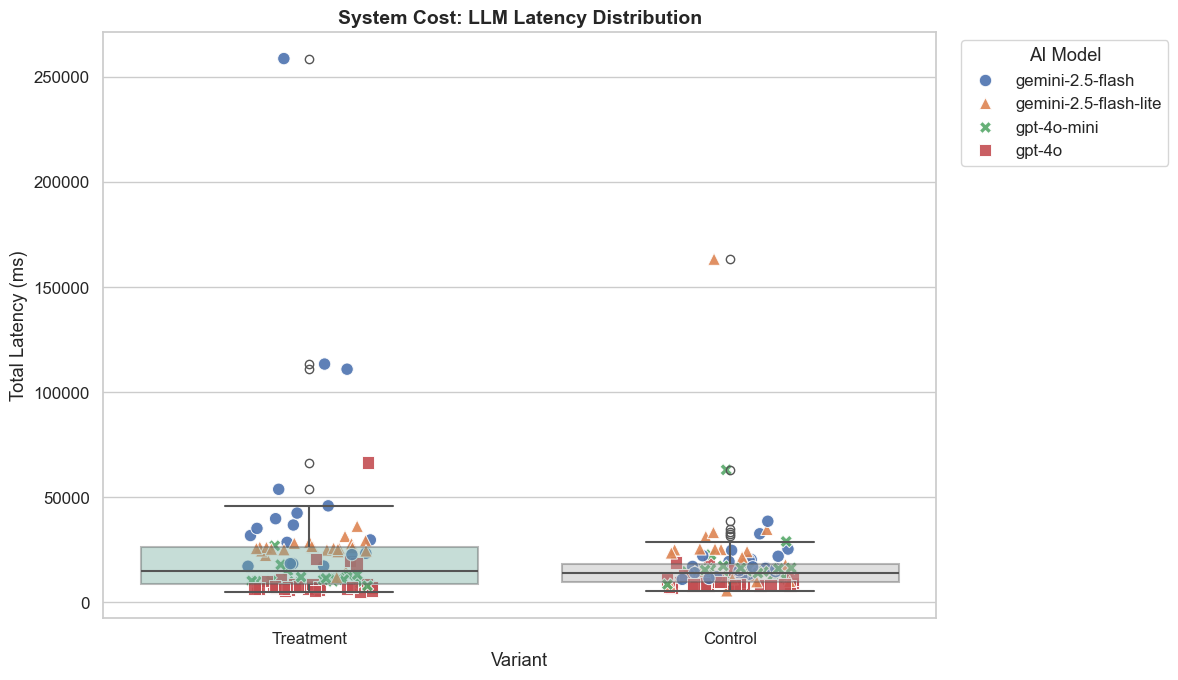

--- Latency Statistical Test (Welch's T-Test) ---
Mean Latency (Control):   16852 ms
Mean Latency (Treatment): 22747 ms
P-Value: 0.0993
Insight: No significant impact on system latency.


In [11]:
# --- GUARDRAIL 2: LATENCY ANALYSIS ---
# We analyze Total Latency (time waiting for LLM) to see if the Treatment adds "System Cost".

plt.figure(figsize=(12, 7))

# 1. Boxplot Background
order = ['Treatment', 'Control']
sns.boxplot(
    data=df, x='Variant', y='Total_Latency_ms', hue='Variant', order=order,
    palette=VARIANT_PALETTE, linewidth=1.5, boxprops={'alpha': 0.4}, dodge=False
)

# 2. Jittered Scatterplot for Model visibility
x_map = {v: i for i, v in enumerate(order)}
# Recalculate jitter for this plot
df['jitter_x_lat'] = df['Variant'].map(x_map) + np.random.uniform(-0.15, 0.15, len(df))

sns.scatterplot(
    data=df, x='jitter_x_lat', y='Total_Latency_ms', 
    hue='Model', style='Model', 
    markers=MODEL_MARKERS, palette="deep", s=80, alpha=0.9, edgecolor="white"
)

plt.xticks(ticks=list(x_map.values()), labels=list(x_map.keys()))
plt.title('System Cost: LLM Latency Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Total Latency (ms)')
plt.legend(title='AI Model', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig("images/metric_latency.png")
plt.show()

# Statistical Test (T-Test for Latency)
control_lat = df[df['Variant']=='Control']['Total_Latency_ms']
treat_lat = df[df['Variant']=='Treatment']['Total_Latency_ms']

t_stat, p_val = stats.ttest_ind(control_lat, treat_lat, equal_var=False)
print(f"--- Latency Statistical Test (Welch's T-Test) ---")
print(f"Mean Latency (Control):   {control_lat.mean():.0f} ms")
print(f"Mean Latency (Treatment): {treat_lat.mean():.0f} ms")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    diff = treat_lat.mean() - control_lat.mean()
    direction = "SLOWER" if diff > 0 else "FASTER"
    print(f"Insight: The Treatment is significantly {direction} ({abs(diff):.0f} ms difference).")
else:
    print("Insight: No significant impact on system latency.")

## 8. Final Conclusion

The experiment tested whether "Friendly" error messages (Treatment) improve agent performance compared to "Cryptic" error codes (Control) when resolving a **Port Conflict** scenario (starting an Apache Web Server blocked by a rogue process). The results strongly suggest **rejecting the hypothesis** that friendly messages reduce friction.

### 1. Primary Outcome: Significant Regression
Contrary to expectations, the "Friendly" Treatment **degraded** performance across almost all metrics:
* **Success Rate:** Dropped significantly from **44.9% (Control)** to **26.9% (Treatment)** ($p=0.0129$). The verbose error messages regarding the port conflict likely acted as distractors rather than guides.
* **Efficiency:** Even among successful sessions (Survivors), the Treatment group was **significantly slower** (+1.99 steps, $p=0.0083$).

### 2. Interaction Effect: Model Fragility vs. Overconfidence
The subgroup analysis revealed distinct failure modes for different model families:
* **Gemini Models (The "Honest Failures"):** Showed high sensitivity to the Treatment. They became significantly slower ($p=0.01$) and failed more often, but maintained a **0% Hallucination Rate**. When they failed to find the rogue process, they timed out honestly.
* **GPT Models (The "Confident Liars"):** Were unaffected by the Treatment in terms of speed ($p=0.71$), but exhibited a severe **~50% Hallucination Rate** across both variants. They frequently claimed to start the Apache Server without actually killing the blocking process first.

### 3. System Cost
There was no statistically significant impact on System Latency ($p=0.09$), indicating that the regression was caused by **Cognitive Friction** (extra reasoning steps) rather than raw token generation time.

**Recommendation:**
Do **not** deploy the "Friendly" error messages. Stick to the "Control" (Cryptic) schema for now, as it forces agents to rely on tool execution (checking `netstat`) rather than semantic guessing. Future work must address the high hallucination rate in GPT models before they can be trusted with autonomous repair tasks.